In [31]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import json
from datetime import datetime, date
import os
import shapefile
from shapely.geometry import box
from datetime import datetime as dt
from sentinelhub import CRS, BBox, DataCollection, SentinelHubCatalog, SHConfig
from sentinelhub.aws import AwsDownloadClient
import pyproj
import rasterio
from rasterio.mask import mask
from shapely.ops import transform
from rasterio.io import MemoryFile
import earthpy.plot as ep
from folium import Map, GeoJson, Figure
import rioxarray as rxr




from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import yaml
# open shape files for Cameroon
import geopandas as gpd


warnings.filterwarnings('ignore')

In [2]:
# Open file for credentials
PATH = '/Users/noeliaotero/Documents/Geo_analysis/'
# Read YAML file
with open(PATH + "credentials.yml", 'r') as stream:
    credentials_conf = yaml.safe_load(stream)
with open(PATH + "config_sentinel.yml", 'r') as stream:
    s_conf = yaml.safe_load(stream)


In [258]:

shafile_file = "/Users/noeliaotero/Documents/Geo_analysis/cmr/cmr.shp"
sh_cmr = gpd.read_file("/Users/noeliaotero/Documents/Geo_analysis/cmr/cmr.shp")

<AxesSubplot: >

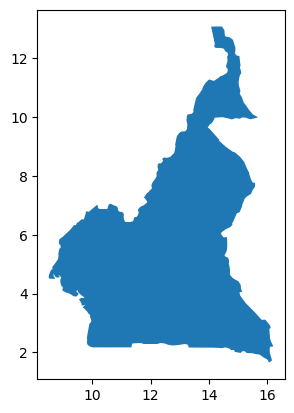

In [259]:
sh_cmr.plot()

In [3]:
gdf = gpd.read_file(s_conf['footprint_file'])
# Set the crs to EPSG 4326 in case of our data is in aonther crs
gdf  = gdf.to_crs("EPSG:4326")
# Get AOI bounds
bbox_aoi = gdf.geometry.total_bounds
# Get AOI centroid for plotting with folium
centroid_aoi = [box(*bbox_aoi).centroid.x, box(*bbox_aoi).centroid.y]
print(centroid_aoi)

[12.177475309471191, 5.02154295782988]


In [4]:
# connect to the API
api = SentinelAPI(credentials_conf['user'], credentials_conf['password'], 'https://apihub.copernicus.eu/apihub')

In [5]:
footprint = geojson_to_wkt(read_geojson(s_conf['footprint_file']))

In [6]:
products = api.query(footprint,
                     date = (date(2020,1,1),date(2020,2,10)),
                     platformname = s_conf['platformname'],
                     processinglevel = s_conf['processinglevel'],
                     cloudcoverpercentage = (0, 20))
# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
images_df = api.to_geodataframe(products)
key_columns = ["platformserialidentifier", "processinglevel", "cloudcoverpercentage", 
               "vegetationpercentage", "beginposition"]
images_df[key_columns].head(5)
# GeoJSON FeatureCollection containing footprints and metadata of the scenes
# api.to_geojson(products)

,platformserialidentifier,processinglevel,cloudcoverpercentage,vegetationpercentage,beginposition
f82c51c1-75e7-4093-89c9-0d549e7148cd,Sentinel-2B,Level-2A,0.007701,66.813558,2020-02-01 09:31:19.024
dc1d877e-9f41-4cad-8ce7-c64aefbb577b,Sentinel-2A,Level-2A,0.000153,66.832477,2020-01-27 09:32:41.024
fc1f6e27-49a0-4023-91cf-4d583b704d7e,Sentinel-2A,Level-2A,2.690634,79.795659,2020-01-24 09:22:51.024
122ee24b-7884-4efa-aebf-7326b4178439,Sentinel-2B,Level-2A,0.425236,67.686826,2020-01-19 09:22:19.024
5cc8cce3-aa97-4ed4-9007-2f67a7b5b54c,Sentinel-2A,Level-2A,0.008349,84.519786,2020-01-14 09:23:31.024


In [7]:
if (len(images_df)>1):
    print(f"Number of products available: {len(images_df)}")
    print(f"Downloading product: {images_df.head(s_conf['download_index'])['title']}")

    # Select and download product to data directory.
    images_df = images_df.head(s_conf['download_index'])  # Get desired product based on selected index.
    cwd = os.getcwd()  # remember current work directory (CWD).
    os.chdir(s_conf['data_dir'])  # Change directory.
    api.download_all(products)
    #api.download_all(images_df.index)  # Download product. Needs '.index' as it cannot download df directly.
    os.chdir(cwd)  # Return to project directory.


Number of products available: 7
Name: title, dtype: object


Fetching archival status: 100%|██████████| 7/7 [00:02<00:00,  2.90product/s]





























































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [8]:
# Unzip the files downloaded
from utils import * 
unzip(s_conf) 
# remove zip *


In [ ]:
# Now the tiff files must be created 
# https://medium.com/analytics-vidhya/two-ways-of-extracting-points-of-interest-from-sentinel-2a-data-baa124b1ed92

### Band extraction

In [9]:
# Extract bands: info: https://gisgeography.com/sentinel-2-bands-combinations/
#B02 : BLUE, B03 : GREEN, B04 : REG, B08 : NIR, B11: SWIR, B12: SWIR
bands = ["B02", "B03", "B04", "B08"]
resolutions = ["10", "10", "10", "10"]
#bands = ["B02", "B03", "B04", "B08", "B8A", "B11", "B12"]
#resolutions = ["R10m", "R10m", "R10m", "R10m", "R20m", "R20m", "R20m"]
bands_and_resolutions = list(zip(bands, resolutions))

target_dim = (516, 516) # reduce dim.

In [10]:
#Function to retrieve metadata
def get_metadata(image_folder, band, resolution=10):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R{resolution}m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == band][0]
    
    with rasterio.open(f"{image_folder_path}/{selected_file}") as infile:
        metadata = infile.meta.copy()
            
    return metadata

def get_band(image_folder, band, resolution=10):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R{resolution}m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == band][0]
    
    with rasterio.open(f"{image_folder_path}/{selected_file}") as infile:
        img = infile.read(1)
            
    return img

In [11]:
tiff_root_data_dir = '/Users/noeliaotero/Documents/Geo_analysis/data/tiff/'

In [21]:
os.chdir(s_conf['data_dir'])
data_dirs = []
for image_folder in os.listdir(s_conf['data_dir']):
    if image_folder.endswith('SAFE'):
        #print(image_folder)
        date = image_folder.split("_")[2].split("T")[0]
        tiff_file = os.path.join(tiff_root_data_dir, date + ".tiff")
        # Extract the bands
        band_dict = {}
        metadata_dict = {}
        for i, (band, resolution) in enumerate(bands_and_resolutions, start=1):
            band_dict[band] = get_band(image_folder, band, resolution)
            metadata_dict[band] = get_metadata(image_folder, band, resolution)
            #print(band_dict[band].shape)
            out_meta = metadata_dict[band]
            out_meta.update({"count": len(bands)})
        band_all = np.dstack(band_dict.values())

        band_all = band_all.transpose(2, 0 ,1)
        #Write to the output file
        with rasterio.open(tiff_file , "w", **out_meta) as dest:
                    dest.write(band_all)


    

In [22]:
aoi = gpd.read_file(s_conf['footprint_file'])

In [229]:

import rasterio as rio
src= rio.open(tiff_file)

In [23]:
def get_bounds_of_AoI(obj_aoi, src_crs):
    
    aoi = gpd.read_file(obj_aoi)
    
    bounds = aoi.total_bounds
    
    offset = 1/60  #2000m in degree

    # WGS84 coordinates
    minx, miny = bounds[0]-offset, bounds[1]-offset
    maxx, maxy = bounds[2]+offset, bounds[3]+offset

    bbox = box(minx, miny, maxx, maxy)
    
    print(bbox)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

    #picking up the coordinate system of the image:
    #crs=src.crs.to_epsg()
    geo = geo.to_crs(crs=src_crs) #src.crs.to_epsg())

    coords = getFeatures(geo)
    
    return coords


In [24]:
def clip_raster_with_bounds(in_tif, out_tif, coords):

    #load the mosaided file
    data = rasterio.open(in_tif)

    out_img, out_transform = rasterio.mask.mask(dataset=data, shapes=coords, crop=True)

    # Copy the metadata
    out_meta = data.meta.copy()

    # Parse EPSG code
    epsg_code = int(data.crs['init'][5:])

    out_meta.update({"driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform,
            "crs": epsg_code} #pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
            )

    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

    print(out_tif)

In [25]:
def get_src_crs(prototype_tif):
    
    with rasterio.open(prototype_tif, 'r') as test:
        src_crs = test.crs.to_epsg()
        
    return src_crs

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [26]:
# Set directory for downloading the quad tiles to
root_dir= '/Users/noeliaotero/Documents/Geo_analysis/data/tiff/'
sentinel_clip_dir = os.path.join(root_dir,'test/') # <= customized to month/year of interest
if not os.path.exists(sentinel_clip_dir):
    os.makedirs(sentinel_clip_dir)
    
image_file_out = os.path.join(sentinel_clip_dir,'test.tif')

In [28]:
src_crs = get_src_crs(tiff_file)
print(src_crs)

32632


In [29]:
coords = get_bounds_of_AoI(s_conf['footprint_file'] ,src_crs)
clip_raster_with_bounds(tiff_file,image_file_out, coords)

POLYGON ((12.194141976137859 5.004876291163213, 12.194141976137859 5.038209624496546, 12.160808642804524 5.038209624496546, 12.160808642804524 5.004876291163213, 12.194141976137859 5.004876291163213))
/Users/noeliaotero/Documents/Geo_analysis/data/tiff/test/test.tif


In [32]:
# Visualization

data = rxr.open_rasterio(image_file_out, masked=True)
data


<xarray.DataArray (band: 4, y: 372, x: 373)>
[555024 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 8.505e+05 8.506e+05 ... 8.543e+05 8.543e+05
  * y            (y) float64 5.578e+05 5.577e+05 ... 5.541e+05 5.54e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

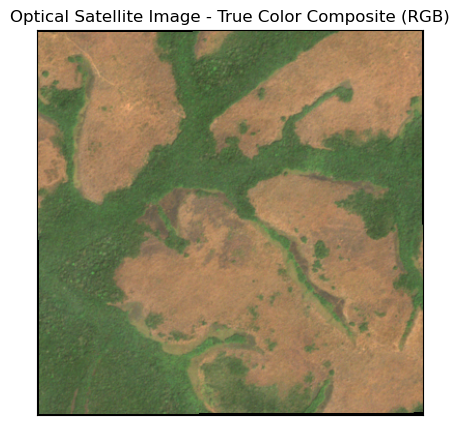

In [35]:
#Set band combinason
band_indices = [2, 1, 0]
#Plot Optical Satellite Image/True color composite
ep.plot_rgb(data.values,
            rgb=band_indices,
            title="Optical Satellite Image - True Color Composite (RGB)", 
            figsize=(5, 5),
           )
plt.show()

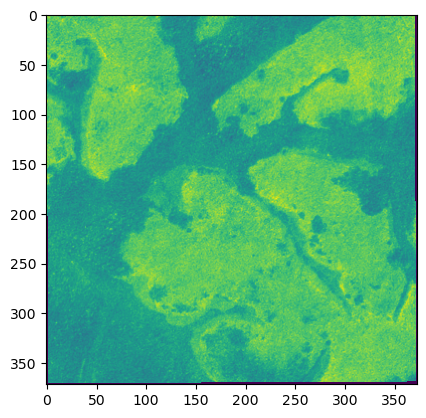

In [37]:
# Plot bands
plt.imshow(data[0,...])